# Dataframe for Dynamic Pricing

## Objectives

This document intends to briefly describe one alternative for the ETL process for the Dynamic Pricing problem at Olist.  
As the end product, we would like to have a table with the proper structure for forecasting techniques.  
The datasets will be described along the way.

### Importing packages

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot     as plt

### Dataframe with complete range

Let's start by creating a dataframe with every data point we want to measure. It will contain hourly intervals, equally spaced between two dates.  
You can change the parameters in the cell below:

In [4]:
freq = 'H' # 'H' is for hourly data. You can use 'D' for days, 'W' for last day of week, 'Q' for quarter, etc.

start_date = '1/1/2018' # MM/DD/YYYY
end_date = '4/1/2020' # MM/DD/YYYY

In [5]:
df = pd.DataFrame(data=pd.date_range(start='1/1/2018', end='4/1/2020', freq=freq),
                  columns=['date'])

df.head(2)

,date
0,2018-01-01 00:00:00
1,2018-01-01 01:00:00


In [6]:
df.tail(2)

,date
19703,2020-03-31 23:00:00
19704,2020-04-01 00:00:00


### Orders dataset

Let's investigate our first dataset "orders.csv". It contains information for every sale that was executed in a given period of time.  
Our main idea is to aggregate sales data and merge it with our dates dataframe (df).

In [7]:
# READING ORDERS DATA AND TRANSFORMING COLUMNS
orders = pd.read_csv('data/orders.csv', dtype={'product_gtin':'str','origin_zip':'str',
                                               'destination_zip':'str'})

orders['purchase_timestamp'] = pd.to_datetime(orders['purchase_timestamp'])

In [8]:
orders.head()

,purchase_timestamp,seller_id,product_gtin,product_sku,channel_slug,channel_store,price,freight_value,price_freight_shift,commission_product_olist,commission_freight_olist,origin_zip,origin_state,origin_city,destination_zip,destination_state,destination_city
0,2019-07-20 11:19:43,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6952202281890,PRDWRHUYLLMFX2U0,mercadolivre,mercadolivre,82.99,20.86,0.0,0.20,0.20,01109010,SP,SAO PAULO,89265575,SC,Jaraguá do Sul
1,2019-11-11 20:43:23,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6951003643197,PRDACYVT895VMO7H,mercadolivre,mercadolivre,119.90,0.00,0.0,0.20,0.20,01109010,SP,SAO PAULO,06040470,SP,Osasco
2,2020-03-01 16:25:00,c58b83e5-52de-43fe-8399-a7bc312e2aa5,7898907175302,PRDKTDU50G9FVV57,cnova,ex,39.90,14.24,0.0,0.19,0.19,20910970,RJ,RIO DE JANEIRO,22260210,RJ,Rio de Janeiro
3,2020-02-04 12:04:10,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6951003643197,PRDACYVT895VMO7H,mercadolivre,mercadolivre,130.95,0.00,0.0,0.20,0.20,01109010,SP,SAO PAULO,89062100,SC,Blumenau
4,2018-12-14 13:52:19,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6951003643197,PRDACYVT895VMO7H,mercadolivre,mercadolivre,128.99,21.51,0.0,0.20,0.20,01109010,SP,SAO PAULO,66055000,PA,Belém


In [9]:
orders.product_gtin.nunique()

647

###### Selecting specific product

In the orders dataset, we have sales information for 647 different products.  
For simplification purposes, let's choose one single product for analysis and manipulation of the dataset.  
To do so, choose a single gtin (str) in the cell below.

- gtin = '7908243600137'
- product_sku = 'PRD41RHHBF9NQR74'
- canonical_sku = 'PRDIM5XOLWMUM0HU'


In [10]:
# SELECTED GTIN

gtin = '7908243600137'

In [11]:
# FILTERING ORDERS DATASET BY CHOSEN GTIN

filter_orders = orders[orders['product_gtin']==gtin][['purchase_timestamp','product_gtin',
                                                                 'price','freight_value',
                                                                 'commission_product_olist','commission_freight_olist']].copy()

# ADD ARTIFICIAL COLUMN WITH THE NUMBER OF ORDERS -> WILL BE USED TO COUNT THE ORDERS BY HOUR
filter_orders['orders'] = 1


# GROUPS ORDERS BY CHOSEN FREQUENCY
filter_orders = filter_orders.groupby([pd.Grouper(key='purchase_timestamp', freq=freq),'product_gtin'])\
                  .agg({'price':'mean', 
                        'freight_value':'mean',
                        'commission_product_olist':'mean',
                        'commission_freight_olist':'mean',
                        'orders':'sum'}).reset_index()

In [13]:
filter_orders.head()

,purchase_timestamp,product_gtin,price,freight_value,commission_product_olist,commission_freight_olist,orders
0,2019-03-27 20:00:00,7908243600137,199.8,22.03,0.2,0.2,1
1,2019-03-28 10:00:00,7908243600137,199.8,27.14,0.2,0.2,1
2,2019-03-31 18:00:00,7908243600137,199.8,16.00,0.2,0.2,1
3,2019-04-03 10:00:00,7908243600137,199.8,16.00,0.2,0.2,1
4,2019-04-03 12:00:00,7908243600137,199.8,9.99,0.2,0.2,1


In [14]:
orders.describe()

,price,freight_value,price_freight_shift,commission_product_olist,commission_freight_olist
count,40997.000000,40997.000000,40997.000000,40997.000000,40997.000000
mean,110.292697,18.431204,0.110380,0.192374,0.188754
std,139.258356,17.080063,1.511568,0.016219,0.030310
min,6.920000,0.000000,0.000000,0.090000,0.000000
25%,35.130000,8.530000,0.000000,0.190000,0.190000
50%,71.900000,16.220000,0.000000,0.200000,0.200000
75%,134.900000,23.110000,0.000000,0.200000,0.200000
max,5079.940000,344.700000,72.900000,0.250000,0.250000


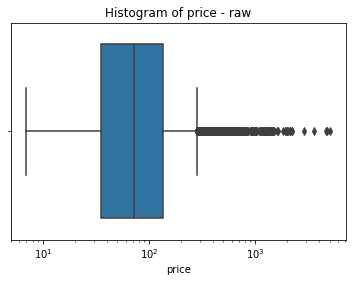

In [18]:
g = sns.boxplot(orders['price'])
g.set_title('Boxplot of price - raw')
g.set_xscale('log')

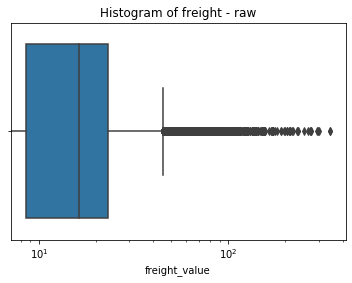

In [19]:
g = sns.boxplot(orders['freight_value'])
g.set_title('Boxplot of freight - raw')
g.set_xscale('log')

From the plots above, we see a broad range of prices and freights. but with mostly concentrated below 300 reais for prices and 35 reais for freight. As we have many diferents prices, we'll apply normalization by each gtin to check the distribution.


Text(0.5, 1.0, 'Boxplot of normalized prices')

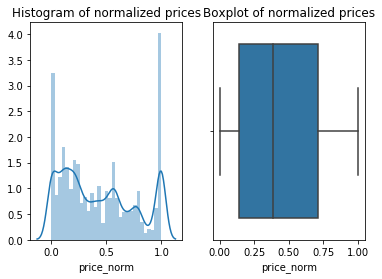

In [30]:
#groupby gtin, calculating min and max to normalize prices and check the distribution.
orders_min = orders.groupby(['product_gtin'])['price'].min()
orders_max = orders.groupby(['product_gtin'])['price'].max()
orders_norm = orders[{'product_gtin','price'}]
orders_norm = orders_norm.merge(orders_max, on = 'product_gtin')
orders_norm = orders_norm.merge(orders_min, on = 'product_gtin')
#price_x == original price, price_y == max price, price == min price. I dont know why its not working.
orders_norm['price_norm'] = (orders_norm['price_x']- orders_norm['price']) / (orders_norm['price_y'] - orders_norm['price'])
fig, ax = plt.subplots(1,2)
sns.distplot(orders_norm['price_norm'], ax=ax[0]).set_title('Histogram of normalized prices')
sns.boxplot(orders_norm['price_norm'], ax=ax[1]).set_title('Boxplot of normalized prices')


It's possible observe a concentration of prices at min and max for each gtin. An the the possible 'outliers was as a matter of fact, products with differents prices. 

##TO DO!
- we need normalize the freights to check? I think so.
- behaviour of normalized prices over time?

#### Identify the main products by volume

In [32]:
#Looking for the most frequent orders bby gtin.
#Here, we don't have the information of how many units was each order.
#As at least one product was sold at each order, I considered that I sell one product by order.
#I choose an random column to count the rows and identify how many orders we have for each gtin
orders_bygtin = orders.groupby(by=['product_gtin'])['seller_id'].count().sort_values(ascending = False).to_frame().rename(columns={'seller_id': 'n_orders'})
orders_bygtin = orders_bygtin.reset_index()
orders_bygtin['share'] = orders_bygtin['n_orders']/orders_bygtin['n_orders'].sum() * 100
orders_bygtin['rank'] = orders_bygtin['share'].rank(method = 'first', ascending = False).astype(int)
orders_bygtin.head()

,product_gtin,n_orders,share,rank
0,8800550956404,2859,6.973681,1
1,7899495703106,2079,5.071103,2
2,7909389621864,1999,4.875967,3
3,7895099385786,1652,4.029563,4
4,7892049060281,1614,3.936873,5


In [33]:
orders_bygtin['share'][orders_bygtin['rank'] <= 20].sum()

48.86455106471205

the top 20 (3%) products concentrates almost 50% of the orders

#### Identify the main products by revenues

In [34]:
orders_byrev = orders.groupby(by=['product_gtin'])['price'].sum().sort_values(ascending = False).to_frame().rename(columns={'price': 'revenue'})
orders_byrev = orders_byrev.reset_index()
orders_byrev['share'] = orders_byrev['revenue']/orders_byrev['revenue'].sum() * 100
orders_byrev['rank'] = orders_byrev['share'].rank(method = 'first', ascending = False).astype(int)
orders_byrev['share'][orders_byrev['rank'] <= 20].sum()


52.62487671893607

The top 20 products (3%) concentrates more than 50% of revenues

##### merge date_range dataframe and orders

Now that we have the number of sales of a given product by hour, along with its average price, average shipping values and average commissions (percentage), we can join with our date range dataframe.  

The 'NaN' rows are the ones that did not have any sales.

In [18]:
# MERGE DF and Filter orders

merged = pd.merge(df, filter_orders, how='left', left_on='date', right_on='purchase_timestamp')
merged.drop('purchase_timestamp', axis=1, inplace=True)

In [19]:
merged.head()

,date,product_gtin,price,freight_value,commission_product_olist,commission_freight_olist,orders
0,2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Checking some rows with sales

merged[merged['orders'].notnull()].head()

,date,product_gtin,price,freight_value,commission_product_olist,commission_freight_olist,orders
10820,2019-03-27 20:00:00,7908243600137,199.8,22.03,0.2,0.2,1.0
10834,2019-03-28 10:00:00,7908243600137,199.8,27.14,0.2,0.2,1.0
10914,2019-03-31 18:00:00,7908243600137,199.8,16.00,0.2,0.2,1.0
10978,2019-04-03 10:00:00,7908243600137,199.8,16.00,0.2,0.2,1.0
10980,2019-04-03 12:00:00,7908243600137,199.8,9.99,0.2,0.2,1.0


### Product_info dataset

Another available dataset is the "product_info.csv". We will use it to check when a product was created in our database to fine tune the starting point of our time series.

In [21]:
prod_info = pd.read_csv('data/product_info.csv', dtype={'gtin':'str'})

prod_info['created_at'] = pd.to_datetime(prod_info['created_at'])

# product creation date

# Get minimum creation date
filter_prod = prod_info[prod_info['gtin']==gtin][['gtin','created_at']]
filter_prod = filter_prod[filter_prod['created_at']==min(filter_prod['created_at'])]
filter_prod = filter_prod.groupby(pd.Grouper(key='created_at',freq=freq)).min().reset_index()

In [22]:
filter_prod

,created_at,gtin
0,2019-03-15 15:00:00,7908243600137


In [23]:
creation_date = filter_prod.iloc[0]['created_at']

##### Filter merged based on creation date

In [24]:
# filter merged dataframe to keep only the dates after the creation date.
merged = merged[merged['date']>=creation_date].copy()

# fill gtin backfill information
merged['product_gtin'] = merged['product_gtin'].fillna(method='bfill')
# fill NaN orders with 0 - no orders on that timestamp
merged['orders'] = merged['orders'].fillna(value=0)

In [25]:
merged.head()

,date,product_gtin,price,freight_value,commission_product_olist,commission_freight_olist,orders
10527,2019-03-15 15:00:00,7908243600137,NaN,NaN,NaN,NaN,0.0
10528,2019-03-15 16:00:00,7908243600137,NaN,NaN,NaN,NaN,0.0
10529,2019-03-15 17:00:00,7908243600137,NaN,NaN,NaN,NaN,0.0
10530,2019-03-15 18:00:00,7908243600137,NaN,NaN,NaN,NaN,0.0
10531,2019-03-15 19:00:00,7908243600137,NaN,NaN,NaN,NaN,0.0


In [27]:
merged.reset_index(drop=True, inplace=True)

### Competition

Now, let's get our competitor's prices by the same frequency.

In [28]:
# Read data and format it
competition = pd.read_csv('data/competition.csv', dtype={'gtin':'str'})

competition['updated_at'] = pd.to_datetime(competition['updated_at'])

# FILTER GTIN
competition = competition[competition['gtin'] == gtin]

In [32]:
competition.head()

,updated_at,gtin,value,slug
41107,2019-12-19 13:24:33,7908243600137,172.70,sieve-b2w-shoptime
41108,2019-12-18 10:51:29,7908243600137,155.43,sieve-b2w-shoptime
41109,2019-12-18 10:50:54,7908243600137,172.70,olist-carrefour
41110,2019-12-18 10:45:32,7908243600137,172.70,olist-b2w
41111,2019-12-18 10:31:49,7908243600137,172.70,olist-cnova


In [33]:
# filter competition on extremely low and high prices
std = competition['value'].std()
mean = competition['value'].mean()

competition = competition[(competition['value']>= mean-3*std) & (competition['value']<= mean+3*std)]

In [34]:
# Group by hour and get minimum value
competition = competition.groupby([pd.Grouper(key='updated_at', freq=freq),'gtin']).min()[['value']].reset_index()

In [35]:
competition.head()

,updated_at,gtin,value
0,2019-03-15 15:00:00,7908243600137,217.8
1,2019-03-15 21:00:00,7908243600137,217.8
2,2019-03-19 13:00:00,7908243600137,217.8
3,2019-03-21 17:00:00,7908243600137,199.8
4,2019-04-03 16:00:00,7908243600137,219.9


##### merge competition prices with merged dataframe

In [ ]:
merged['day'] = merged['date'].apply(lambda x: x.date())

In [43]:
merged = pd.merge(merged, competition,
         left_on=['date','product_gtin'], right_on=['updated_at', 'gtin'],
         how='left')

merged.rename(columns={'value':'competition_price'}, inplace=True)

merged = merged[['date', 'product_gtin',  'competition_price', 'price', 'freight_value',
       'commission_product_olist', 'commission_freight_olist', 'orders']].copy()

In [46]:
merged.head()

,date,product_gtin,competition_price,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders
0,2019-03-15 15:00:00,7908243600137,217.8,217.8,NaN,NaN,NaN,NaN,0.0
1,2019-03-15 16:00:00,7908243600137,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2019-03-15 17:00:00,7908243600137,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2019-03-15 18:00:00,7908243600137,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2019-03-15 19:00:00,7908243600137,NaN,NaN,NaN,NaN,NaN,NaN,0.0


We will forward fill the competition price.

In [59]:
merged['competition_price'].fillna(method='ffill', inplace=True)

In [60]:
merged.head()

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders
0,2019-03-15 15:00:00,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0
1,2019-03-15 16:00:00,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0
2,2019-03-15 17:00:00,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0
3,2019-03-15 18:00:00,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0
4,2019-03-15 19:00:00,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0


### Product type and group

Let's gather some information about the type of the analyzed product.

This particular gtin belongs to the product_type "Kit para cabelo" (Hair Care Kit).  
The product belongs to the broader group "beleza_saude" (beauty_health)

In [71]:
product_type = pd.read_csv('data/product_type.csv', dtype={'value':str})

In [72]:
product_type.head()

,odin,product_type,product_type_group,identifier_type,value
0,O1657A805FB85C4E76BDEF8E5B9037492D,Avental,vestuario,gtin,0000110010494
1,O14121ABC7E11848C58BE87C91943F88B6,Avental,vestuario,gtin,0000110010500
2,O13E8792B144BF4F44824BC80017AA7A47,Teste de condição da água,limpeza,gtin,0000116001007
3,O19E2B76CEE87F48E3AFB32017EFE29993,Estabilizador biológico para aquário,petshop,gtin,0000116006309
4,O1C5805AEDB9624FBDB43D7A4DECABA0F2,Estabilizador biológico para aquário,petshop,gtin,0000116006507


In [73]:
product_type[product_type['value']==gtin]

,odin,product_type,product_type_group,identifier_type,value
442047,O13611D830738843C9BC91E70EFF99163E,Kit para cabelo,beleza_saude,gtin,7908243600137


In [75]:
merged.columns

Index(['date', 'product_gtin', 'competition_price', 'price', 'freight_value',
       'commission_product_olist', 'commission_freight_olist', 'orders'],
      dtype='object')

In [78]:
merged = pd.merge(left=merged, right=product_type,
         left_on='product_gtin', right_on='value')[['date', 'product_gtin', 'competition_price',
                                                    'price', 'freight_value', 'commission_product_olist', 
                                                    'commission_freight_olist', 'orders','product_type', 
                                                    'product_type_group']]

In [79]:
merged.head()

,date,product_gtin,competition_price,price,freight_value,commission_product_olist,commission_freight_olist,orders,product_type,product_type_group
0,2019-03-15 15:00:00,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0,Kit para cabelo,beleza_saude
1,2019-03-15 16:00:00,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0,Kit para cabelo,beleza_saude
2,2019-03-15 17:00:00,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0,Kit para cabelo,beleza_saude
3,2019-03-15 18:00:00,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0,Kit para cabelo,beleza_saude
4,2019-03-15 19:00:00,7908243600137,217.8,NaN,NaN,NaN,NaN,0.0,Kit para cabelo,beleza_saude


### Olist history of prices
### TODO

For this particular case, we will only read historical data for the selected gtin. This will be changed once olist can share data on other products.  
Due to internal issues, the price history could not be gathered.


In [50]:
history = pd.read_csv('data/product_history.csv', dtype={'gtin':str})
history['updated_at'] = pd.to_datetime(history['updated_at'])